# TISSUE filtering improvements on real spatial transcriptomics data

This notebook contains code for running the experiments showing improvements in TISSUE filtering over unfiltered predicted gene expression inputs for various downstream tasks including supervised learning (classification), clustering, and visualization.

It relies on the outputs of `spatial_conformal_uncertainty.py` followed by `get_calibration.py` applied to all eleven benchmark dataset pairs. In particular, it requires running the Python commands in all the job scripts of form: `run_conformal_{i}.slurm`. The h5ad anndata objects should be saved into "scg_results/scpi/2023Aug1_k4k1_SDbasedCCPplus1/" with respect to the current working directory (or an alternative path for stratified grouping results).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import umap
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *

from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
label_mapper = {'Dataset3celltype': "Mouse Hipp. (seqFISH) - Cell type",
                'Dataset13celltype_lowres': "Mouse VISP (ISS) - Cell type",
                'Dataset14region': "Drosophila Embryo (FISH) - Region",
                'Dataset15ClusterName': "Mouse SC (osmFISH) - Cell type",
                'Dataset15Region': "Mouse SC (osmFISH) - Region",
                'Dataset1celltype_mapped_refined': "Mouse Gast. (seqFISH) - Cell type",
                'AxolotlAnnotation': "Axolotl Brain (Stereo-seq) - Cell type"}

## TISSUE Cell Filtering with all Downstream Metrics

Following code block runs the cell filtering experiments and records various downstream performance metrics across all datasets, prediction methods, etc.

In [3]:
# Set up experiment parameters
experiment_name = "REVISED"
dirnames = ["2023Aug1_k4k1_SDbasedCCPplus1", "2023Aug1_kautokauto_SDbasedCCPplus1"]
dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15", "Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["celltype", "celltype_lowres", "region", "Region", "ClusterName", "celltype_mapped_refined", "Annotation"]
methods = ['knn', 'spage', 'tangram']
n_classes = 3
filter_proportion = "otsu"


######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Directory"] = []
df_dict["Label"] = []
df_dict["Imputation Method"] = []
df_dict["Approach"] = []

df_dict["Accuracy"] = []
df_dict["F1"] = []
df_dict["ROC_AUC"] = []
df_dict["ARI"] = []
df_dict["Separability"] = []

for dirname in dirnames:
    for di, d in enumerate(dataset_names):
        
        label = metadata_labels[di]
        
        adata = sc.read_h5ad(f"scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI.h5ad")

        # subset into observations falling into most prevalent classes (if specified)
        uniq_labels, counts = np.unique(adata.obs[label], return_counts=True)
        if len(uniq_labels) > n_classes:
            sorted_uniq_labels = uniq_labels[np.argsort(counts)][::-1][:n_classes]
            adata = adata[adata.obs[label].isin(sorted_uniq_labels)]

        for m in methods:
            
            predicted = f'{m}_predicted_expression'
            
            # get prediction intervals
            adata.obsm[f'{predicted}_hi'] = adata.obsm[f'{predicted}_hi_67']
            adata.obsm[f'{predicted}_lo'] = adata.obsm[f'{predicted}_lo_67']
            
            ######################################################
            # Predictive modeling (classification evaluation)
            ######################################################
            
            # Imputed - Uncertainty
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            splits = kf.split(X, adata.obs[label])
            unc_acc = []
            unc_f1 = []
            unc_roc_auc = []
            for i, (train_index, test_index) in enumerate(splits):
                # get train test
                X_train = X[train_index,:].copy()
                X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
                y_train = adata.obs[label].values[train_index]
                X_test = X[test_index,:].copy()
                X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
                y_test = adata.obs[label].values[test_index]
                # filter both independently
                keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
                keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
                # fit model
                model = LogisticRegression(penalty='l1', solver='liblinear')
                scaler = StandardScaler()
                X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
                model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
                # evaluate
                pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
                pred_y_test_scores = model.predict_proba(scaler.transform(X_test[keep_idxs_test,:]))
                unc_acc.append(accuracy_score(y_test[keep_idxs_test], pred_y_test))
                unc_f1.append(f1_score(y_test[keep_idxs_test], pred_y_test, average='macro'))
                unc_roc_auc.append(roc_auc_score(y_test[keep_idxs_test], pred_y_test_scores, multi_class='ovr'))

            unc_acc = np.mean(unc_acc)
            unc_f1 = np.mean(unc_f1)
            unc_roc_auc = np.mean(unc_roc_auc)

            # Imputed
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            X = StandardScaler().fit_transform(X)
            imp_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            imp_acc = imp_dict['test_accuracy'].mean()
            imp_f1 = imp_dict['test_f1_macro'].mean()
            imp_roc_auc = imp_dict['test_roc_auc_ovr'].mean()

            # Measured
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.X
            X = StandardScaler().fit_transform(X)
            measured_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            measured_acc = measured_dict['test_accuracy'].mean()
            measured_f1 = measured_dict['test_f1_macro'].mean()
            measured_roc_auc = measured_dict['test_roc_auc_ovr'].mean()
            
            
            ##### Set up data for CLUSTERING and VISUALIZATION
            labels = adata.obs[label].values.copy()
            
            # Imputed - Uncertainty
            unc_keep_idxs = filtered_PCA(adata, m, proportion=filter_proportion, stratification=labels,
                                         return_keep_idxs=True)
            #print(len(unc_keep_idxs)/adata.shape[0])
            X_red_imp_unc_fil = adata.uns[predicted+'_PC15_filtered_'].copy()

            # Imputed
            filtered_PCA(adata, m, proportion=0, stratification=labels)
            X_red_imp = adata.obsm[predicted+'_PC15_'].copy()

            # Measured
            X = adata.X
            X = StandardScaler().fit_transform(X)
            X_red_measured = PCA(n_components=15).fit_transform(X)
            
            
            ######################################################
            # Clustering (ARI)
            ######################################################
            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp_unc_fil)
            clusters = kmeans.labels_
            unc_fil_ari = adjusted_rand_score(labels[unc_keep_idxs], clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp)
            clusters = kmeans.labels_
            imp_ari = adjusted_rand_score(labels, clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_measured)
            clusters = kmeans.labels_
            measured_ari = adjusted_rand_score(labels, clusters)
    
            
            ######################################################
            # Visualization (Linear Separability)
            ######################################################

            #### Linear separability
            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_unc_fil, labels[unc_keep_idxs])
            unc_fil_sep = clf.score(X_red_imp_unc_fil, labels[unc_keep_idxs])

            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp, labels)
            imp_sep = clf.score(X_red_imp, labels)

            clf = SVC(kernel='linear', random_state=444).fit(X_red_measured, labels)
            measured_sep = clf.score(X_red_measured, labels)
            
            
            # Append results to dictionary
            df_dict["Dataset"] += [d,d,d]
            df_dict["Label"] += [label, label, label]
            df_dict["Directory"] += [dirname, dirname, dirname]
            df_dict["Imputation Method"] += [m,m,m]
            df_dict["Approach"] += ["Imputed", "Imputed-Uncertainty", "Measured"]
            df_dict["Accuracy"] += [imp_acc, unc_acc, measured_acc]
            df_dict["F1"] += [imp_f1, unc_f1, measured_f1]
            df_dict["ROC_AUC"] += [imp_roc_auc, unc_roc_auc, measured_roc_auc]
            df_dict["ARI"] += [imp_ari, unc_fil_ari, measured_ari]
            df_dict["Separability"] += [imp_sep, unc_fil_sep, measured_sep]

In [8]:
# uncomment to save results
# with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "wb") as f:
#     pickle.dump(df_dict, f)

### Selected figures for osmFISH dataset with region labels

Make plots of performance metrics for Baseline, TISSUE, and Measured for the mouse somatosensory cortex osmFISH dataset paired with anatomic region labels.

In [9]:
# load dictionary of results from pickle file
experiment_name = "REVISED"
n_classes = 3

with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "rb") as f:
    df_dict = pickle.load(f)

In [10]:
# make dataframe from dict
df = pd.DataFrame(df_dict)
df["Dataset_Label"] = df["Dataset"] + df["Label"]

# Filter df
datasets = ["Dataset15Region"] 
directories = ["2023Aug1_k4k1_SDbasedCCPplus1"]

df = df[df["Dataset_Label"].isin(datasets)]
df = df[df["Directory"].isin(directories)]

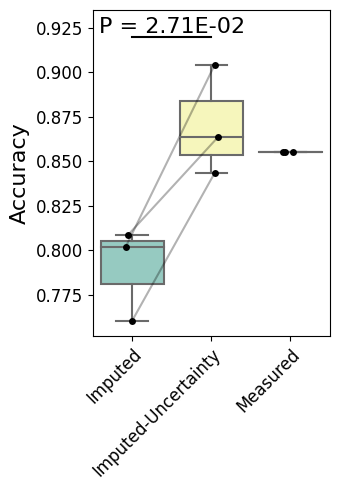

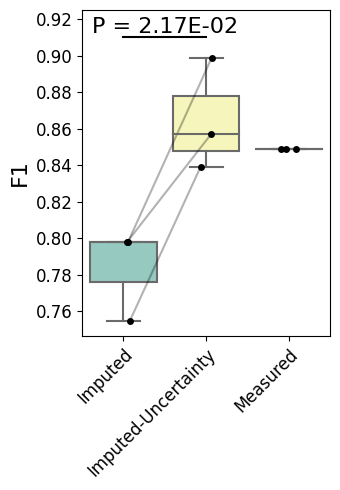

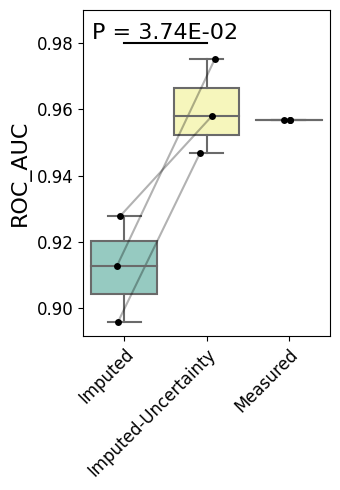

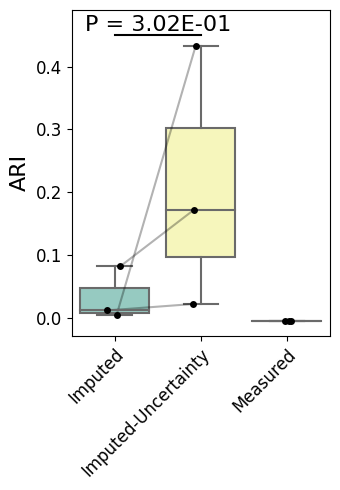

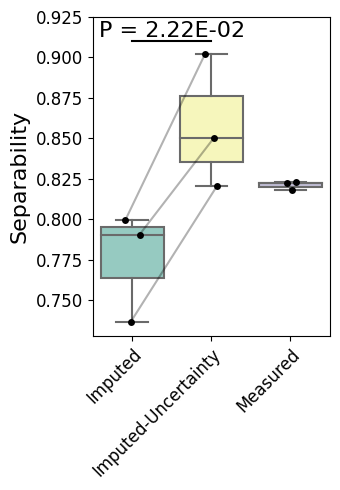

In [11]:
# Dataset15Region - k4k1
yoffs = [0.015,0.015,0.01,0.04,0.015]
ymaxs = [0.92,0.91,0.98,0.45,0.91]

measures = ["Accuracy","F1","ROC_AUC","ARI","Separability"]

for mi, measure in enumerate(measures):
    
    # key for TISSUE result 
    tissue_key = "Imputed-Uncertainty"
    
    # outdated code to adjust for old formatting
    if "Imputed-Uncertainty-Filtered" in df["Approach"].values:
        if measure in ["Accuracy", "F1", "ROC_AUC"]:
            prediction_df = df[df["Approach"]!="Imputed-Uncertainty-Filtered"].copy()
        else:
            prediction_df = df[df["Approach"]!="Imputed-Uncertainty"].copy()
            prediction_df["Approach"] = ["Imputed-Uncertainty" if x=="Imputed-Uncertainty-Filtered" else x for x in prediction_df["Approach"]]
    else:
        prediction_df = df
        
    # Make Plot
    fig, ax = plt.subplots(figsize=(3.5,5))

    sns.stripplot(data=prediction_df, x="Approach", y=measure, c='k')
    sns.boxplot(data=prediction_df, x="Approach", y=measure, palette="Set3", showfliers=False)

    # Draw connecting lines
    locs1 = ax.get_children()[0].get_offsets()
    locs2 = ax.get_children()[1].get_offsets()
    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2[i, 0]]
        y = [locs1[i, 1], locs2[i, 1]]
        ax.plot(x, y, color="black", alpha=0.3)

    # statistical annotation
    x_coords = [0.5]
    y_coords = [ymaxs[mi]]
    cols = ['k']
    h = 0
    w = 0.5
    t,p = ttest_rel(prediction_df[prediction_df["Approach"]=="Imputed"][measure], prediction_df[prediction_df["Approach"]==tissue_key][measure])
    pval_labels = [p]
    for i, label in enumerate(pval_labels):
        p_label = "P = "+ '%.2E' % Decimal(str(label))
        x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)

    plt.ylim(None, y+yoffs[mi])

    plt.xlabel("", fontsize=0)
    plt.ylabel(measure, fontsize=16)
    plt.xticks(fontsize=12, rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plots/scpi_prediction/REVISED_predictionMetadata_LogReg_Cellapproach_67cutoff_{measure}.pdf", bbox_inches="tight")
    plt.show()

### For automated stratified grouping

In [12]:
df = pd.DataFrame(df_dict)
df["Dataset_Label"] = df["Dataset"] + df["Label"]

# Filter df
datasets = ["Dataset15Region"]
directories = ["2023Aug1_kautokauto_SDbasedCCPplus1"]

df = df[df["Dataset_Label"].isin(datasets)]
df = df[df["Directory"].isin(directories)]

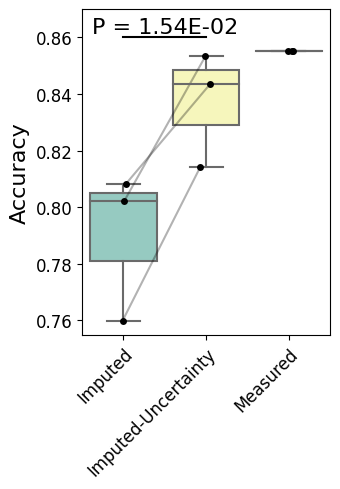

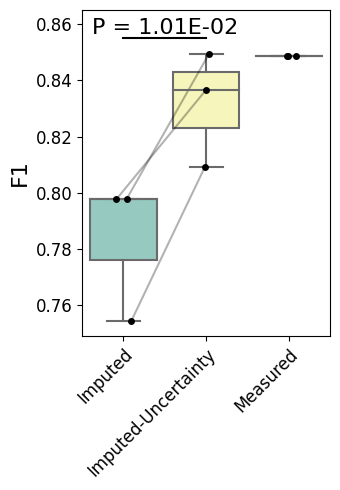

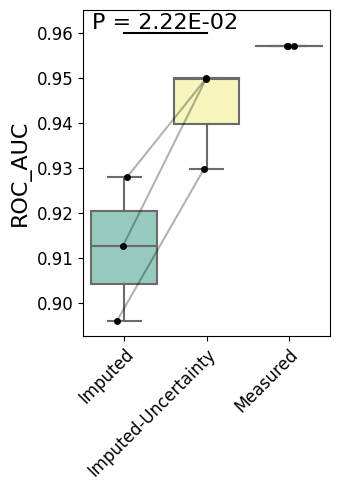

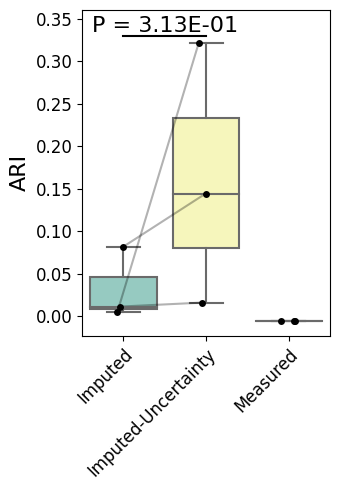

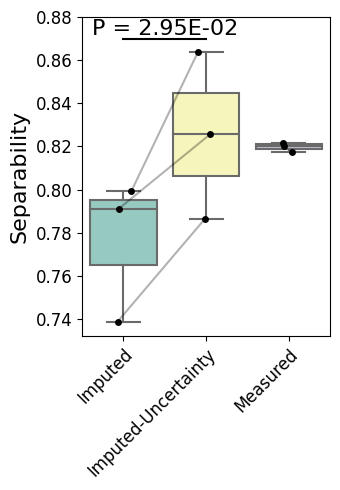

In [13]:
# Dataset15Region - kauto
yoffs = [0.01,0.01,0.005,0.03,0.01]
ymaxs = [0.86,0.855,0.96,0.33,0.87]

measures = ["Accuracy","F1","ROC_AUC","ARI","Separability"]

for mi, measure in enumerate(measures):
    
    # key for TISSUE result 
    tissue_key = "Imputed-Uncertainty"
    
    # outdated code to adjust for old formatting
    if "Imputed-Uncertainty-Filtered" in df["Approach"].values:
        if measure in ["Accuracy", "F1", "ROC_AUC"]:
            prediction_df = df[df["Approach"]!="Imputed-Uncertainty-Filtered"].copy()
        else:
            prediction_df = df[df["Approach"]!="Imputed-Uncertainty"].copy()
            prediction_df["Approach"] = ["Imputed-Uncertainty" if x=="Imputed-Uncertainty-Filtered" else x for x in prediction_df["Approach"]]
    else:
        prediction_df = df
    
    # Make plot
    fig, ax = plt.subplots(figsize=(3.5,5))

    sns.stripplot(data=prediction_df, x="Approach", y=measure, c='k')
    sns.boxplot(data=prediction_df, x="Approach", y=measure, palette="Set3", showfliers=False)

    # Draw connecting lines
    locs1 = ax.get_children()[0].get_offsets()
    locs2 = ax.get_children()[1].get_offsets()
    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2[i, 0]]
        y = [locs1[i, 1], locs2[i, 1]]
        ax.plot(x, y, color="black", alpha=0.3)

    # statistical annotation
    x_coords = [0.5]
    y_coords = [ymaxs[mi]]
    cols = ['k']
    h = 0
    w = 0.5
    t,p = ttest_rel(prediction_df[prediction_df["Approach"]=="Imputed"][measure], prediction_df[prediction_df["Approach"]==tissue_key][measure])
    pval_labels = [p]
    for i, label in enumerate(pval_labels):
        p_label = "P = "+ '%.2E' % Decimal(str(label))
        x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)

    plt.ylim(None, y+yoffs[mi])

    plt.xlabel("", fontsize=0)
    plt.ylabel(measure, fontsize=16)
    plt.xticks(fontsize=12, rotation=45, ha='right', rotation_mode='anchor')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"plots/scpi_prediction/REVISED_predictionMetadata_LogReg_Cellapproach_67cutoff_{measure}_kauto.pdf", bbox_inches="tight")
    plt.show()

## Heatmap summary plots for seven dataset-label pairs

Generate heatmap showing log2 fold improvements across all downstream application metrics for all seven dataset and label pairings. Highlights the cases with significant improvements.

In [14]:
# load in dictionary of results from pickle file
experiment_name = "REVISED"
n_classes = 3

with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "rb") as f:
    df_dict = pickle.load(f)

In [15]:
dataset_labels = ['Dataset3celltype','Dataset13celltype_lowres', 
            'Dataset14region', 'Dataset15ClusterName', 'Dataset15Region',
            'Dataset1celltype_mapped_refined', 'AxolotlAnnotation']
metrics = ["Accuracy", "F1", "ROC_AUC", "ARI", "Separability"]
directories = ["2023Aug1_k4k1_SDbasedCCPplus1"]

########### Make Heatmap plot

df = pd.DataFrame(df_dict)
df["Dataset_Label"] = df["Dataset"] + df["Label"]

df = df[df["Directory"].isin(directories)].copy()

# init heatmap values
log2FC = np.zeros((len(dataset_labels),len(metrics)))
paired_ttest_pvalue = np.ones((len(dataset_labels),len(metrics)))

for j, metric in enumerate(metrics):
    
    # outdated code to adjust for old formatting
    if "Imputed-Uncertainty-Filtered" in df["Approach"].values:
        if metric in ["Accuracy", "F1", "ROC_AUC"]:
            tissue_key = "Imputed-Uncertainty"
        else:
            tissue_key = "Imputed-Uncertainty-Filtered"
    else:
        tissue_key = "Imputed-Uncertainty"
    
    # generate statistics (fold change and p-value)
    for i, dl in enumerate(dataset_labels):
        
        subdf = df[df["Dataset_Label"]==dl].copy()
        
        # statistical significance
        t,p = ttest_rel(subdf[subdf["Approach"]=="Imputed"][metric], subdf[subdf["Approach"]==tissue_key][metric])
        paired_ttest_pvalue[i,j] = p
        
        # effect size
        avglogfc = np.log2(np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) / np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric]))
        log2FC[i,j] = avglogfc

/tmp/ipykernel_43/2286343329.py:39: RuntimeWarning: invalid value encountered in log2
  avglogfc = np.log2(np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) / np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric]))


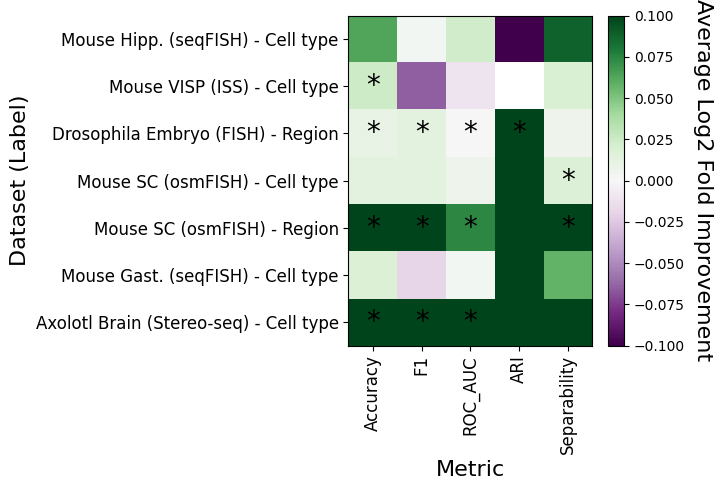

In [16]:
p = 0.05 # cutoff

xticklabels = metrics
yticklabels = [label_mapper[x] for x in dataset_labels]

# make mask with * for significant improvements
sig_mask = paired_ttest_pvalue.copy().astype(str)
sig_mask[paired_ttest_pvalue < p] = "*"
sig_mask[sig_mask != "*"] = ""

# make heatmap and overlay significance
plt.figure(figsize=(7,5))
maxlim = np.max(np.abs(log2FC))
plt.imshow(log2FC, aspect='auto', cmap="PRGn", vmin=-maxlim, vmax=maxlim)
plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Average Log2 Fold Improvement', rotation=270, fontsize=16, labelpad=20)
for i in range(len(yticklabels)):
    for j in range(len(xticklabels)):
        text = plt.text(j, i, sig_mask[i, j],
                       ha="center", va="center", color="k", fontsize=20)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Dataset (Label)", fontsize=16)
plt.tight_layout()
dir_tag = "_".join(directories)
metrics_tag = "_".join(metrics)
plt.savefig(f"plots/scpi_prediction/REVISED_heatmap_{dir_tag}__{metrics_tag}.pdf", bbox_inches="tight")
plt.show()

### With 50% PI width

In [17]:
# Set up experiment parameters
experiment_name = "REVISED_50"
dirnames = ["2023Aug1_k4k1_SDbasedCCPplus1", "2023Aug1_kautokauto_SDbasedCCPplus1"]
dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15", "Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["celltype", "celltype_lowres", "region", "Region", "ClusterName", "celltype_mapped_refined", "Annotation"]
methods = ['knn', 'spage', 'tangram']
n_classes = 3
filter_proportion = "otsu"


######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Directory"] = []
df_dict["Label"] = []
df_dict["Imputation Method"] = []
df_dict["Approach"] = []

df_dict["Accuracy"] = []
df_dict["F1"] = []
df_dict["ROC_AUC"] = []
df_dict["ARI"] = []
df_dict["Separability"] = []

for dirname in dirnames:
    for di, d in enumerate(dataset_names):
        
        label = metadata_labels[di]
        
        adata = sc.read_h5ad(f"scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI.h5ad")

        # subset into observations falling into most prevalent classes (if specified)
        uniq_labels, counts = np.unique(adata.obs[label], return_counts=True)
        if len(uniq_labels) > n_classes:
            sorted_uniq_labels = uniq_labels[np.argsort(counts)][::-1][:n_classes]
            adata = adata[adata.obs[label].isin(sorted_uniq_labels)]

        for m in methods:
            
            predicted = f'{m}_predicted_expression'
            
            # get prediction intervals
            adata.obsm[f'{predicted}_hi'] = adata.obsm[f'{predicted}_hi_50']
            adata.obsm[f'{predicted}_lo'] = adata.obsm[f'{predicted}_lo_50']
            
            ######################################################
            # Predictive modeling (classification evaluation)
            ######################################################
            
            # Imputed - Uncertainty
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            splits = kf.split(X, adata.obs[label])
            unc_acc = []
            unc_f1 = []
            unc_roc_auc = []
            for i, (train_index, test_index) in enumerate(splits):
                # get train test
                X_train = X[train_index,:].copy()
                X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
                y_train = adata.obs[label].values[train_index]
                X_test = X[test_index,:].copy()
                X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
                y_test = adata.obs[label].values[test_index]
                # filter both independently
                keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
                keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
                # fit model
                model = LogisticRegression(penalty='l1', solver='liblinear')
                scaler = StandardScaler()
                X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
                model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
                # evaluate
                pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
                pred_y_test_scores = model.predict_proba(scaler.transform(X_test[keep_idxs_test,:]))
                unc_acc.append(accuracy_score(y_test[keep_idxs_test], pred_y_test))
                unc_f1.append(f1_score(y_test[keep_idxs_test], pred_y_test, average='macro'))
                unc_roc_auc.append(roc_auc_score(y_test[keep_idxs_test], pred_y_test_scores, multi_class='ovr'))

            unc_acc = np.mean(unc_acc)
            unc_f1 = np.mean(unc_f1)
            unc_roc_auc = np.mean(unc_roc_auc)

            # Imputed
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            X = StandardScaler().fit_transform(X)
            imp_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            imp_acc = imp_dict['test_accuracy'].mean()
            imp_f1 = imp_dict['test_f1_macro'].mean()
            imp_roc_auc = imp_dict['test_roc_auc_ovr'].mean()

            # Measured
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.X
            X = StandardScaler().fit_transform(X)
            measured_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            measured_acc = measured_dict['test_accuracy'].mean()
            measured_f1 = measured_dict['test_f1_macro'].mean()
            measured_roc_auc = measured_dict['test_roc_auc_ovr'].mean()
            
            
            ##### Set up data for CLUSTERING and VISUALIZATION
            labels = adata.obs[label].values.copy()
            
            # Imputed - Uncertainty
            unc_keep_idxs = filtered_PCA(adata, m, proportion=filter_proportion, stratification=labels,
                                         return_keep_idxs=True)
            #print(len(unc_keep_idxs)/adata.shape[0])
            X_red_imp_unc_fil = adata.uns[predicted+'_PC15_filtered_'].copy()

            # Imputed
            filtered_PCA(adata, m, proportion=0, stratification=labels)
            X_red_imp = adata.obsm[predicted+'_PC15_'].copy()

            # Measured
            X = adata.X
            X = StandardScaler().fit_transform(X)
            X_red_measured = PCA(n_components=15).fit_transform(X)
            
            
            ######################################################
            # Clustering (ARI)
            ######################################################
            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp_unc_fil)
            clusters = kmeans.labels_
            unc_fil_ari = adjusted_rand_score(labels[unc_keep_idxs], clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp)
            clusters = kmeans.labels_
            imp_ari = adjusted_rand_score(labels, clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_measured)
            clusters = kmeans.labels_
            measured_ari = adjusted_rand_score(labels, clusters)
    
            
            ######################################################
            # Visualization (Linear Separability)
            ######################################################

            #### Linear separability
            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_unc_fil, labels[unc_keep_idxs])
            unc_fil_sep = clf.score(X_red_imp_unc_fil, labels[unc_keep_idxs])

            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp, labels)
            imp_sep = clf.score(X_red_imp, labels)

            clf = SVC(kernel='linear', random_state=444).fit(X_red_measured, labels)
            measured_sep = clf.score(X_red_measured, labels)
            
            
            # Append results to dictionary
            df_dict["Dataset"] += [d,d,d]
            df_dict["Label"] += [label, label, label]
            df_dict["Directory"] += [dirname, dirname, dirname]
            df_dict["Imputation Method"] += [m,m,m]
            df_dict["Approach"] += ["Imputed", "Imputed-Uncertainty", "Measured"]
            df_dict["Accuracy"] += [imp_acc, unc_acc, measured_acc]
            df_dict["F1"] += [imp_f1, unc_f1, measured_f1]
            df_dict["ROC_AUC"] += [imp_roc_auc, unc_roc_auc, measured_roc_auc]
            df_dict["ARI"] += [imp_ari, unc_fil_ari, measured_ari]
            df_dict["Separability"] += [imp_sep, unc_fil_sep, measured_sep]

In [18]:
# with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "wb") as f:
#     pickle.dump(df_dict, f)

In [19]:
experiment_name = "REVISED_50"
n_classes = 3

with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "rb") as f:
    df_dict = pickle.load(f)

In [20]:
dataset_labels = ['Dataset3celltype','Dataset13celltype_lowres', 
            'Dataset14region', 'Dataset15ClusterName', 'Dataset15Region',
            'Dataset1celltype_mapped_refined', 'AxolotlAnnotation']
metrics = ["Accuracy", "F1", "ROC_AUC", "ARI", "Separability"]
directories = ["2023Aug1_k4k1_SDbasedCCPplus1"]

########### Make Heatmap plot

df = pd.DataFrame(df_dict)
df["Dataset_Label"] = df["Dataset"] + df["Label"]

df = df[df["Directory"].isin(directories)].copy()

# init heatmap values
log2FC = np.zeros((len(dataset_labels),len(metrics)))
paired_ttest_pvalue = np.ones((len(dataset_labels),len(metrics)))

for j, metric in enumerate(metrics):
    
    # outdated code to adjust for old formatting
    if "Imputed-Uncertainty-Filtered" in df["Approach"].values:
        if metric in ["Accuracy", "F1", "ROC_AUC"]:
            tissue_key = "Imputed-Uncertainty"
        else:
            tissue_key = "Imputed-Uncertainty-Filtered"
    else:
        tissue_key = "Imputed-Uncertainty"
    
    # generate statistics (fold change and p-value)
    for i, dl in enumerate(dataset_labels):
        
        subdf = df[df["Dataset_Label"]==dl].copy()
        
        # statistical significance
        t,p = ttest_rel(subdf[subdf["Approach"]=="Imputed"][metric], subdf[subdf["Approach"]==tissue_key][metric])
        paired_ttest_pvalue[i,j] = p
        
        # effect size
        avglogfc = np.log2(np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) / np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric]))
        log2FC[i,j] = avglogfc

/tmp/ipykernel_43/2286343329.py:39: RuntimeWarning: invalid value encountered in log2
  avglogfc = np.log2(np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) / np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric]))


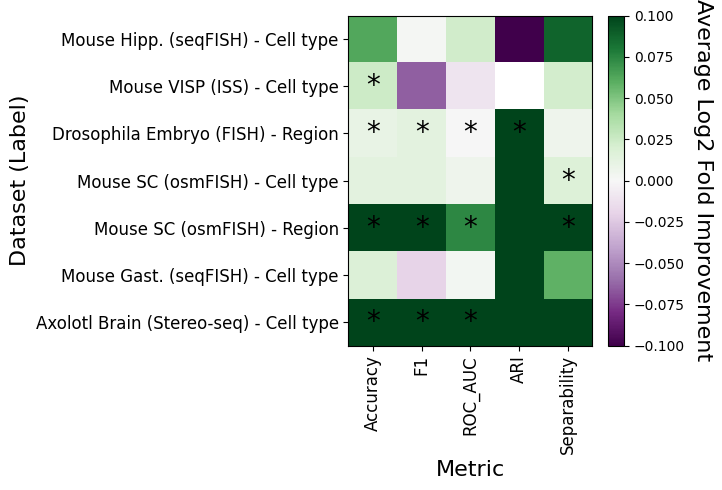

In [21]:
p = 0.05 # cutoff

xticklabels = metrics
yticklabels = [label_mapper[x] for x in dataset_labels]

# make mask with * for significant improvements
sig_mask = paired_ttest_pvalue.copy().astype(str)
sig_mask[paired_ttest_pvalue < p] = "*"
sig_mask[sig_mask != "*"] = ""

# make heatmap and overlay significance
plt.figure(figsize=(7,5))
maxlim = np.max(np.abs(log2FC))
plt.imshow(log2FC, aspect='auto', cmap="PRGn", vmin=-maxlim, vmax=maxlim)
plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Average Log2 Fold Improvement', rotation=270, fontsize=16, labelpad=20)
for i in range(len(yticklabels)):
    for j in range(len(xticklabels)):
        text = plt.text(j, i, sig_mask[i, j],
                       ha="center", va="center", color="k", fontsize=20)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Dataset (Label)", fontsize=16)
plt.tight_layout()
dir_tag = "_".join(directories)
metrics_tag = "_".join(metrics)
plt.savefig(f"plots/scpi_prediction/REVISED_50_heatmap_{dir_tag}__{metrics_tag}.pdf", bbox_inches="tight")
plt.show()

### With 80% PI Width

In [22]:
# Set up experiment parameters
experiment_name = "REVISED_80"
dirnames = ["2023Aug1_k4k1_SDbasedCCPplus1", "2023Aug1_kautokauto_SDbasedCCPplus1"]
dataset_names = ["Dataset3", "Dataset13", "Dataset14", "Dataset15", "Dataset15", "Dataset1", "Axolotl"]
metadata_labels = ["celltype", "celltype_lowres", "region", "Region", "ClusterName", "celltype_mapped_refined", "Annotation"]
methods = ['knn', 'spage', 'tangram']
n_classes = 3
filter_proportion = "otsu"


######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Directory"] = []
df_dict["Label"] = []
df_dict["Imputation Method"] = []
df_dict["Approach"] = []

df_dict["Accuracy"] = []
df_dict["F1"] = []
df_dict["ROC_AUC"] = []
df_dict["ARI"] = []
df_dict["Separability"] = []

for dirname in dirnames:
    for di, d in enumerate(dataset_names):
        
        label = metadata_labels[di]
        
        adata = sc.read_h5ad(f"scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI.h5ad")

        # subset into observations falling into most prevalent classes (if specified)
        uniq_labels, counts = np.unique(adata.obs[label], return_counts=True)
        if len(uniq_labels) > n_classes:
            sorted_uniq_labels = uniq_labels[np.argsort(counts)][::-1][:n_classes]
            adata = adata[adata.obs[label].isin(sorted_uniq_labels)]

        for m in methods:
            
            predicted = f'{m}_predicted_expression'
            
            # get prediction intervals
            adata.obsm[f'{predicted}_hi'] = adata.obsm[f'{predicted}_hi_80']
            adata.obsm[f'{predicted}_lo'] = adata.obsm[f'{predicted}_lo_80']
            
            ######################################################
            # Predictive modeling (classification evaluation)
            ######################################################
            
            # Imputed - Uncertainty
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            splits = kf.split(X, adata.obs[label])
            unc_acc = []
            unc_f1 = []
            unc_roc_auc = []
            for i, (train_index, test_index) in enumerate(splits):
                # get train test
                X_train = X[train_index,:].copy()
                X_train_pi_width = adata.obsm[f'{predicted}_hi'].values[train_index,:] - adata.obsm[f'{predicted}_lo'].values[train_index,:]
                y_train = adata.obs[label].values[train_index]
                X_test = X[test_index,:].copy()
                X_test_pi_width = adata.obsm[f'{predicted}_hi'].values[test_index,:] - adata.obsm[f'{predicted}_lo'].values[test_index,:]
                y_test = adata.obs[label].values[test_index]
                # filter both independently
                keep_idxs_train = detect_uncertain_cells (X_train_pi_width, proportion=filter_proportion, stratification=y_train)
                keep_idxs_test = detect_uncertain_cells (X_test_pi_width, proportion=filter_proportion, stratification=y_test)
                # fit model
                model = LogisticRegression(penalty='l1', solver='liblinear')
                scaler = StandardScaler()
                X_train[keep_idxs_train,:] = scaler.fit_transform(X_train[keep_idxs_train,:])
                model.fit(X_train[keep_idxs_train,:], y_train[keep_idxs_train])
                # evaluate
                pred_y_test = model.predict(scaler.transform(X_test[keep_idxs_test,:]))
                pred_y_test_scores = model.predict_proba(scaler.transform(X_test[keep_idxs_test,:]))
                unc_acc.append(accuracy_score(y_test[keep_idxs_test], pred_y_test))
                unc_f1.append(f1_score(y_test[keep_idxs_test], pred_y_test, average='macro'))
                unc_roc_auc.append(roc_auc_score(y_test[keep_idxs_test], pred_y_test_scores, multi_class='ovr'))

            unc_acc = np.mean(unc_acc)
            unc_f1 = np.mean(unc_f1)
            unc_roc_auc = np.mean(unc_roc_auc)

            # Imputed
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.obsm[predicted].values
            X = StandardScaler().fit_transform(X)
            imp_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            imp_acc = imp_dict['test_accuracy'].mean()
            imp_f1 = imp_dict['test_f1_macro'].mean()
            imp_roc_auc = imp_dict['test_roc_auc_ovr'].mean()

            # Measured
            model = LogisticRegression(penalty='l1', solver='liblinear')
            kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=444)
            X = adata.X
            X = StandardScaler().fit_transform(X)
            measured_dict = cross_validate(model, X, adata.obs[label].values, cv=kf, scoring=["accuracy", "f1_macro", "roc_auc_ovr"])
            measured_acc = measured_dict['test_accuracy'].mean()
            measured_f1 = measured_dict['test_f1_macro'].mean()
            measured_roc_auc = measured_dict['test_roc_auc_ovr'].mean()
            
            
            ##### Set up data for CLUSTERING and VISUALIZATION
            labels = adata.obs[label].values.copy()
            
            # Imputed - Uncertainty
            unc_keep_idxs = filtered_PCA(adata, m, proportion=filter_proportion, stratification=labels,
                                         return_keep_idxs=True)
            #print(len(unc_keep_idxs)/adata.shape[0])
            X_red_imp_unc_fil = adata.uns[predicted+'_PC15_filtered_'].copy()

            # Imputed
            filtered_PCA(adata, m, proportion=0, stratification=labels)
            X_red_imp = adata.obsm[predicted+'_PC15_'].copy()

            # Measured
            X = adata.X
            X = StandardScaler().fit_transform(X)
            X_red_measured = PCA(n_components=15).fit_transform(X)
            
            
            ######################################################
            # Clustering (ARI)
            ######################################################
            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp_unc_fil)
            clusters = kmeans.labels_
            unc_fil_ari = adjusted_rand_score(labels[unc_keep_idxs], clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_imp)
            clusters = kmeans.labels_
            imp_ari = adjusted_rand_score(labels, clusters)

            kmeans = KMeans(n_clusters=n_classes).fit(X_red_measured)
            clusters = kmeans.labels_
            measured_ari = adjusted_rand_score(labels, clusters)
    
            
            ######################################################
            # Visualization (Linear Separability)
            ######################################################

            #### Linear separability
            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_unc_fil, labels[unc_keep_idxs])
            unc_fil_sep = clf.score(X_red_imp_unc_fil, labels[unc_keep_idxs])

            clf = SVC(kernel='linear', random_state=444).fit(X_red_imp, labels)
            imp_sep = clf.score(X_red_imp, labels)

            clf = SVC(kernel='linear', random_state=444).fit(X_red_measured, labels)
            measured_sep = clf.score(X_red_measured, labels)
            
            
            # Append results to dictionary
            df_dict["Dataset"] += [d,d,d]
            df_dict["Label"] += [label, label, label]
            df_dict["Directory"] += [dirname, dirname, dirname]
            df_dict["Imputation Method"] += [m,m,m]
            df_dict["Approach"] += ["Imputed", "Imputed-Uncertainty", "Measured"]
            df_dict["Accuracy"] += [imp_acc, unc_acc, measured_acc]
            df_dict["F1"] += [imp_f1, unc_f1, measured_f1]
            df_dict["ROC_AUC"] += [imp_roc_auc, unc_roc_auc, measured_roc_auc]
            df_dict["ARI"] += [imp_ari, unc_fil_ari, measured_ari]
            df_dict["Separability"] += [imp_sep, unc_fil_sep, measured_sep]

In [23]:
# with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "wb") as f:
#     pickle.dump(df_dict, f)

In [24]:
experiment_name = "REVISED_80"
n_classes = 3

with open(f"results/prediction/{experiment_name}_FilterAllMetrics_LogReg_K{n_classes}_OtsuFilterInCV.pkl", "rb") as f:
    df_dict = pickle.load(f)

In [25]:
dataset_labels = ['Dataset3celltype','Dataset13celltype_lowres', 
            'Dataset14region', 'Dataset15ClusterName', 'Dataset15Region',
            'Dataset1celltype_mapped_refined', 'AxolotlAnnotation']
metrics = ["Accuracy", "F1", "ROC_AUC", "ARI", "Separability"]
directories = ["2023Aug1_k4k1_SDbasedCCPplus1"]

########### Make Heatmap plot

df = pd.DataFrame(df_dict)
df["Dataset_Label"] = df["Dataset"] + df["Label"]

df = df[df["Directory"].isin(directories)].copy()

# init heatmap values
log2FC = np.zeros((len(dataset_labels),len(metrics)))
paired_ttest_pvalue = np.ones((len(dataset_labels),len(metrics)))

for j, metric in enumerate(metrics):
    
    # outdated code to adjust for old formatting
    if "Imputed-Uncertainty-Filtered" in df["Approach"].values:
        if metric in ["Accuracy", "F1", "ROC_AUC"]:
            tissue_key = "Imputed-Uncertainty"
        else:
            tissue_key = "Imputed-Uncertainty-Filtered"
    else:
        tissue_key = "Imputed-Uncertainty"
    
    # generate statistics (fold change and p-value)
    for i, dl in enumerate(dataset_labels):
        
        subdf = df[df["Dataset_Label"]==dl].copy()
        
        # statistical significance
        t,p = ttest_rel(subdf[subdf["Approach"]=="Imputed"][metric], subdf[subdf["Approach"]==tissue_key][metric])
        paired_ttest_pvalue[i,j] = p
        
        # effect size
        avglogfc = np.log2(np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) / np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric]))
        log2FC[i,j] = avglogfc

/tmp/ipykernel_43/2286343329.py:39: RuntimeWarning: invalid value encountered in log2
  avglogfc = np.log2(np.nanmean(subdf[subdf["Approach"]==tissue_key][metric]) / np.nanmean(subdf[subdf["Approach"]=="Imputed"][metric]))


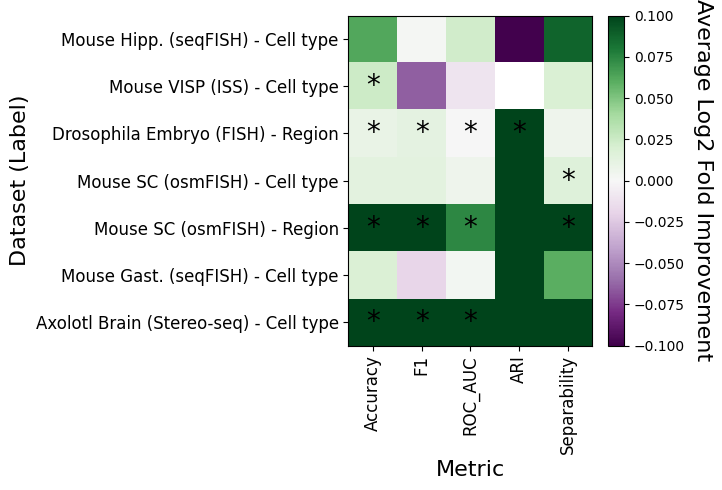

In [26]:
p = 0.05 # cutoff

xticklabels = metrics
yticklabels = [label_mapper[x] for x in dataset_labels]

# make mask with * for significant improvements
sig_mask = paired_ttest_pvalue.copy().astype(str)
sig_mask[paired_ttest_pvalue < p] = "*"
sig_mask[sig_mask != "*"] = ""

# make heatmap and overlay significance
plt.figure(figsize=(7,5))
maxlim = np.max(np.abs(log2FC))
plt.imshow(log2FC, aspect='auto', cmap="PRGn", vmin=-maxlim, vmax=maxlim)
plt.xticks(np.arange(len(xticklabels)), xticklabels, fontsize=12, rotation=90)
plt.yticks(np.arange(len(yticklabels)), yticklabels, fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Average Log2 Fold Improvement', rotation=270, fontsize=16, labelpad=20)
for i in range(len(yticklabels)):
    for j in range(len(xticklabels)):
        text = plt.text(j, i, sig_mask[i, j],
                       ha="center", va="center", color="k", fontsize=20)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Dataset (Label)", fontsize=16)
plt.tight_layout()
dir_tag = "_".join(directories)
metrics_tag = "_".join(metrics)
plt.savefig(f"plots/scpi_prediction/REVISED_80_heatmap_{dir_tag}__{metrics_tag}.pdf", bbox_inches="tight")
plt.show()